Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


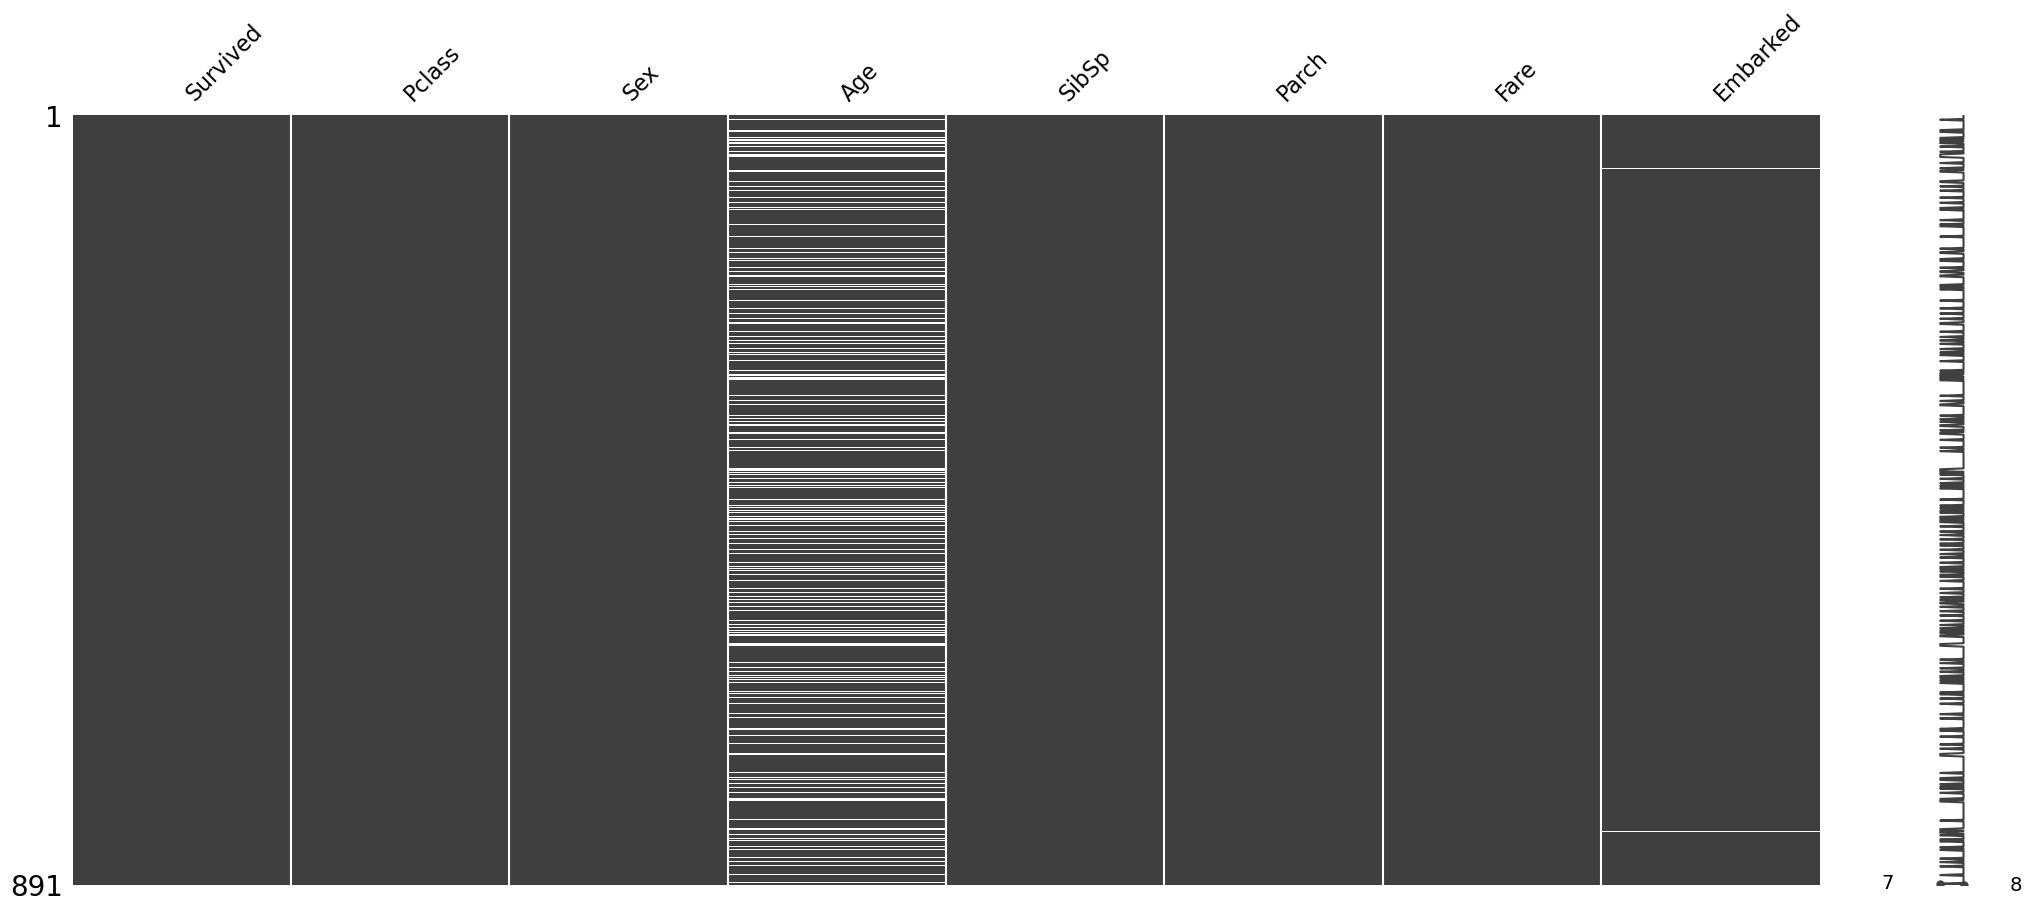

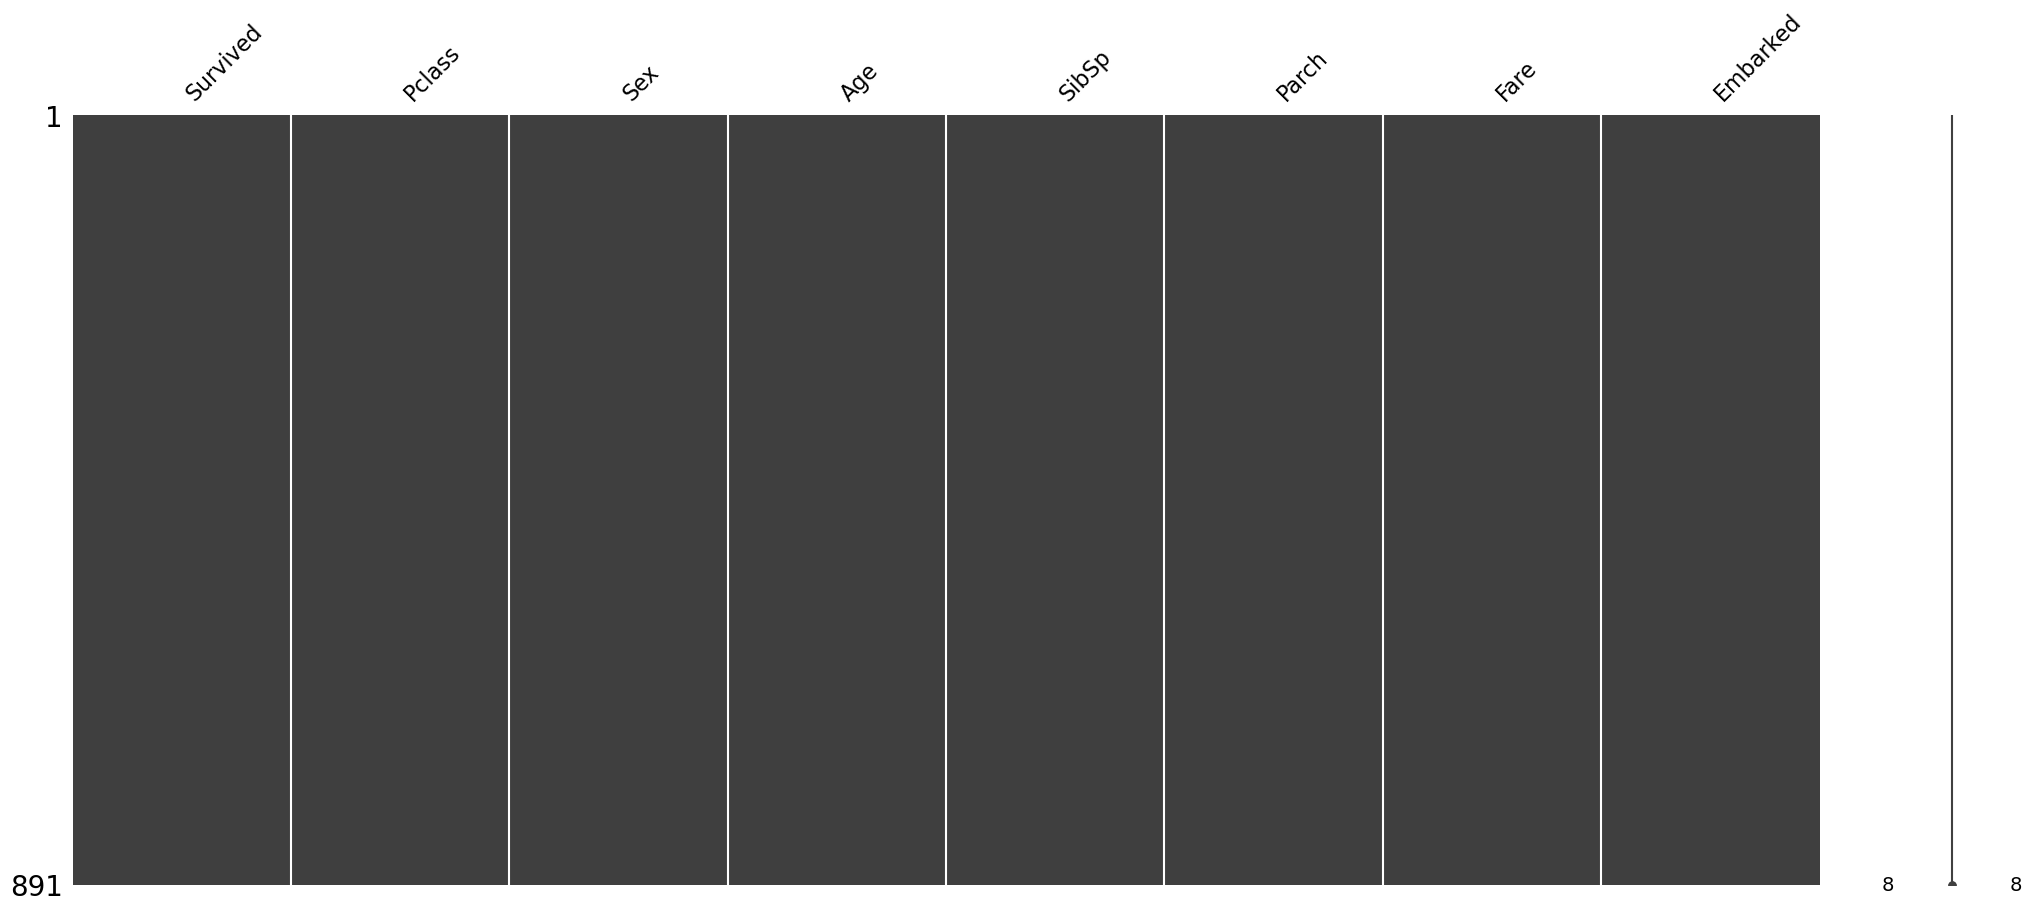

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
df=pd.read_csv("train.csv")
df_2=pd.read_csv("test.csv")
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df_2 = df_2.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
mapping = {1: 'Upper', 2: 'Middle', 3: 'Lower'}
# Reemplazar los valores en la columna 'Pclass'
df['Pclass'] = df['Pclass'].replace(mapping)
df_2['Pclass'] = df_2['Pclass'].replace(mapping)
df['Survived'] = df['Survived'].replace({1: 'Survived', 0: 'No'})
df_2['Survived'] = df['Survived'].replace({1: 'Survived', 0: 'No'})
# Visualización de datos faltantes #
print(msno.matrix(df))
# Imputación #
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df[['Embarked']]), columns=['Embarked'])
df['Embarked']=df_imputed['Embarked']

# Separa las variables cuantitativas de las cualitativas
# Las variables cuantitativas son 'Age' y 'Fare'
quantitative_cols = ['Age', 'Fare']

# Las variables cualitativas son 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
qualitative_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df[quantitative_cols] = knn_imputer.fit_transform(df[quantitative_cols])
#### Segundo datasets
# Imputación #
df_imputed2 = pd.DataFrame(imputer.fit_transform(df_2[['Embarked']]), columns=['Embarked'])
df_2['Embarked']=df_imputed2['Embarked']


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_2[quantitative_cols] = knn_imputer.fit_transform(df_2[quantitative_cols])

# Visualiza la matriz de valores faltantes después de la imputación
print(msno.matrix(df))



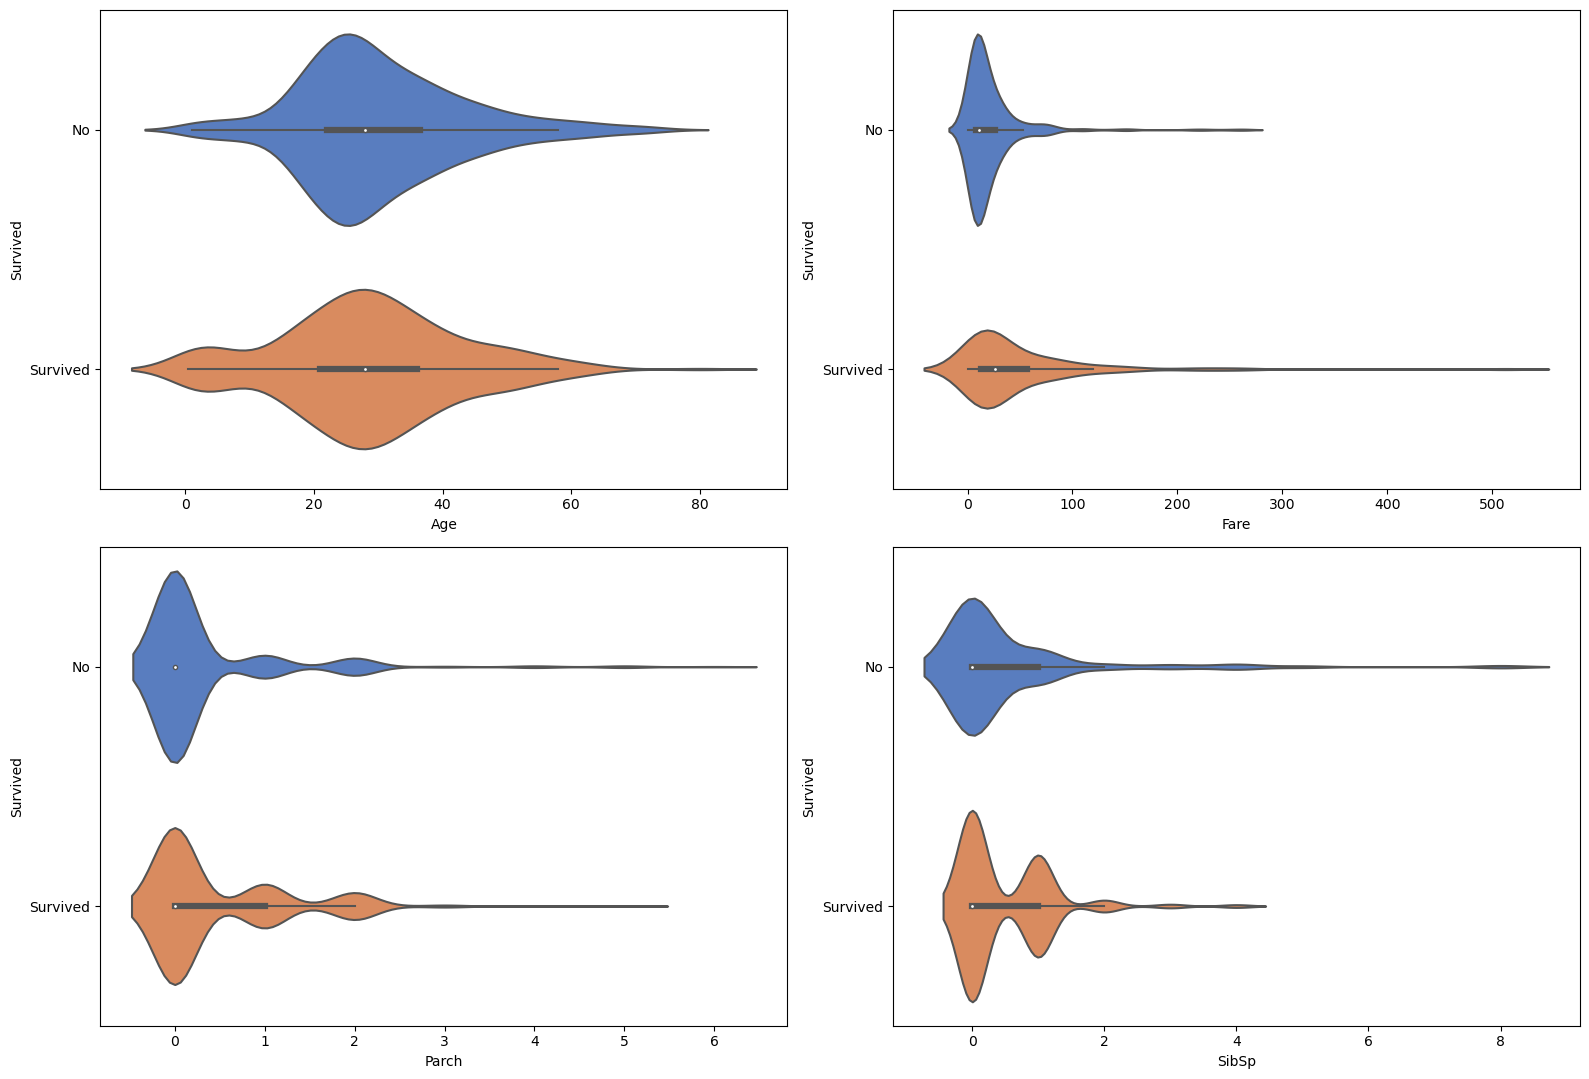

In [2]:
# Asegúrate de que la columna 'Survived' sea categórica para facilitar la visualización
df['Survived'] = df['Survived'].astype('category')

# Definir las variables cualitativas y cuantitativas
qualitative_cols = ['Pclass', 'Sex', 'Embarked']
quantitative_cols = ['Age', 'Fare', 'Parch', 'SibSp']

# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2]
    sns.violinplot(y='Survived', x=col, data=df, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



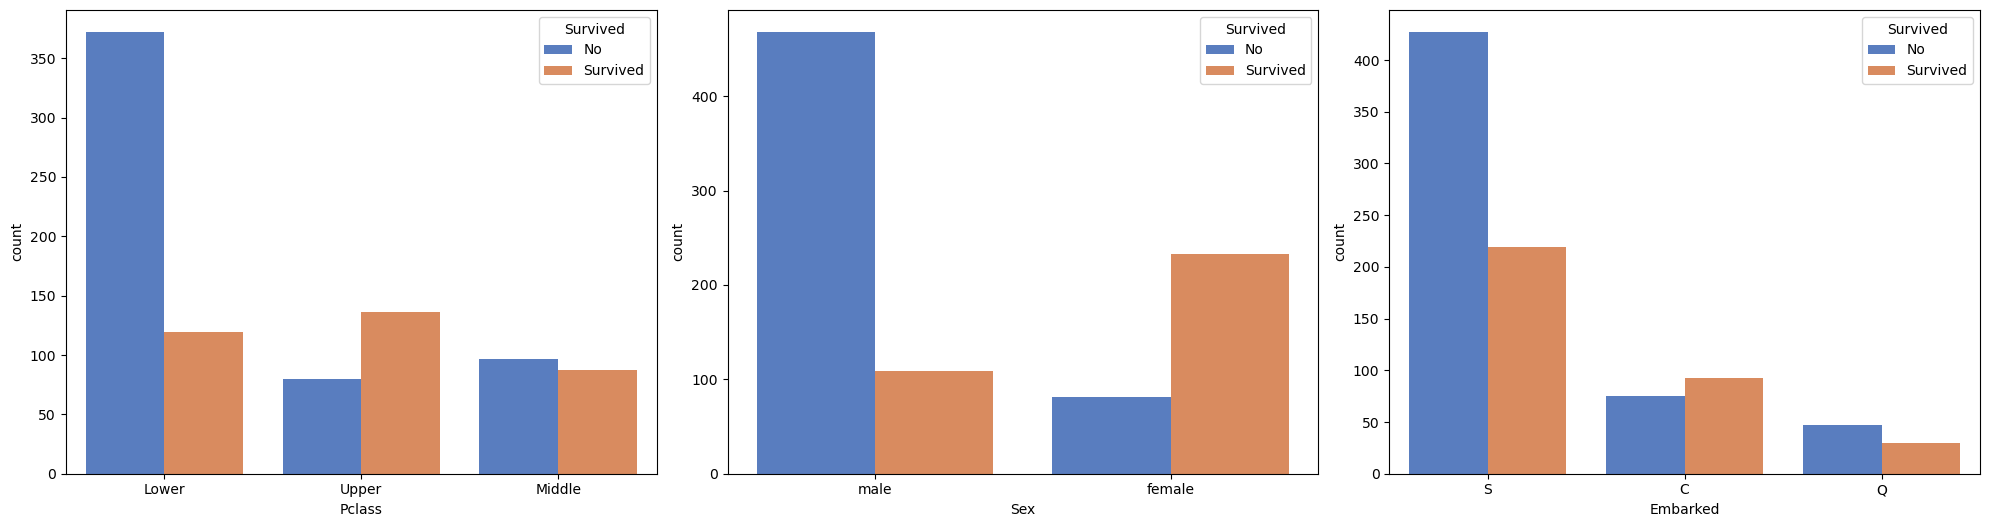

In [3]:
# Crear un tablero para gráficos de barras de variables cualitativas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Survived', data=df, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


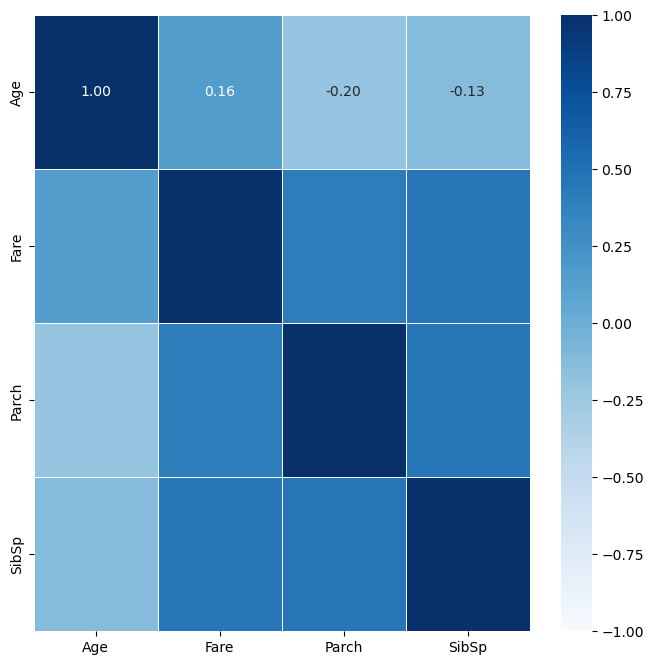

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [4]:
# Correlación

# Calcular la matriz de correlación de Spearman
corr_matrix = df[quantitative_cols].corr(method='spearman')

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, linecolor='white', xticklabels= True, annot=True, fmt=".2f")
plt.show()
df.columns

In [5]:
X_train=df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test=df_2[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y_train=df.iloc[:,0]
y_test=df_2.iloc[:,7]



In [6]:
# Impute missing values in categorical columns
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
X_train[qualitative_cols] = imputer.fit_transform(X_train[qualitative_cols])
X_test[qualitative_cols] = imputer.transform(X_test[qualitative_cols])

# One-hot encode the categorical columns
X_train_encoded = pd.get_dummies(X_train[qualitative_cols], columns=qualitative_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test[qualitative_cols], columns=qualitative_cols, drop_first=True)

# Combine the encoded categorical columns with the numerical columns
X_train_final = pd.concat([X_train_encoded, X_train.drop(columns=qualitative_cols)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test.drop(columns=qualitative_cols)], axis=1)
y_train=df['Survived']
y_test=df_2['Survived']

In [7]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)

In [8]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[156,  99],
       [110,  53]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

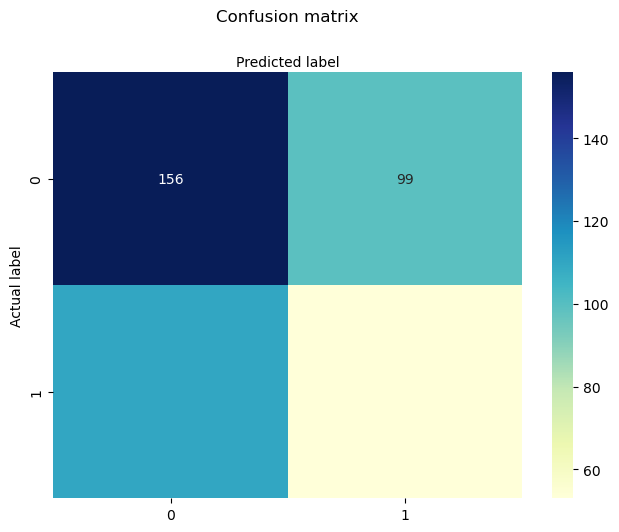

In [9]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [10]:
from sklearn.metrics import classification_report
target_names = ['No', 'Survived']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

          No       0.59      0.61      0.60       255
    Survived       0.35      0.33      0.34       163

    accuracy                           0.50       418
   macro avg       0.47      0.47      0.47       418
weighted avg       0.49      0.50      0.50       418



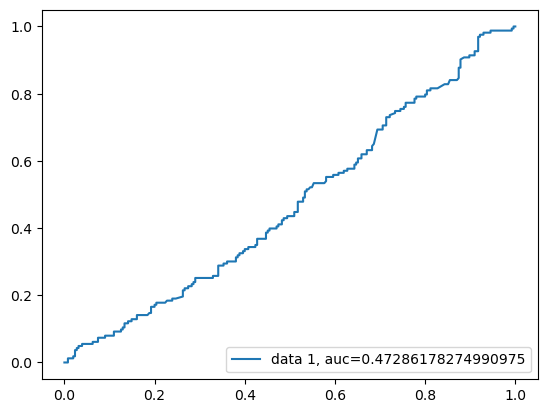

In [11]:
y_test_binary = y_test.map({'No': 0, 'Survived': 1})
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test_binary, y_pred_proba)
auc = metrics.roc_auc_score(y_test_binary, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print(classification_report(y_test, y_pred, target_names=target_names))

[[165  90]
 [108  55]]
              precision    recall  f1-score   support

          No       0.60      0.65      0.62       255
    Survived       0.38      0.34      0.36       163

    accuracy                           0.53       418
   macro avg       0.49      0.49      0.49       418
weighted avg       0.52      0.53      0.52       418



In [13]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CF9F218E10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CF9F21B650>})

In [14]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 124}


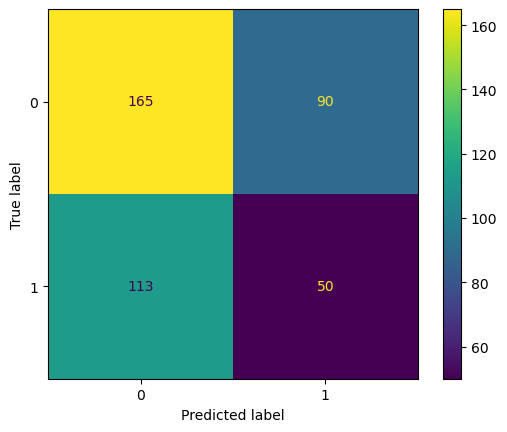

In [15]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test_final)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

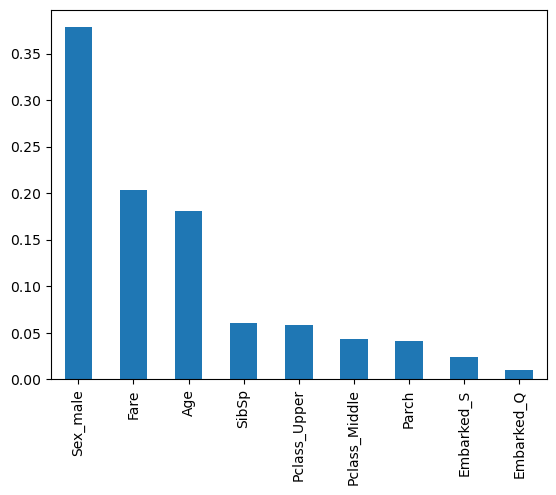

In [16]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test_final.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [17]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [18]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_final,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


In [19]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5143540669856459


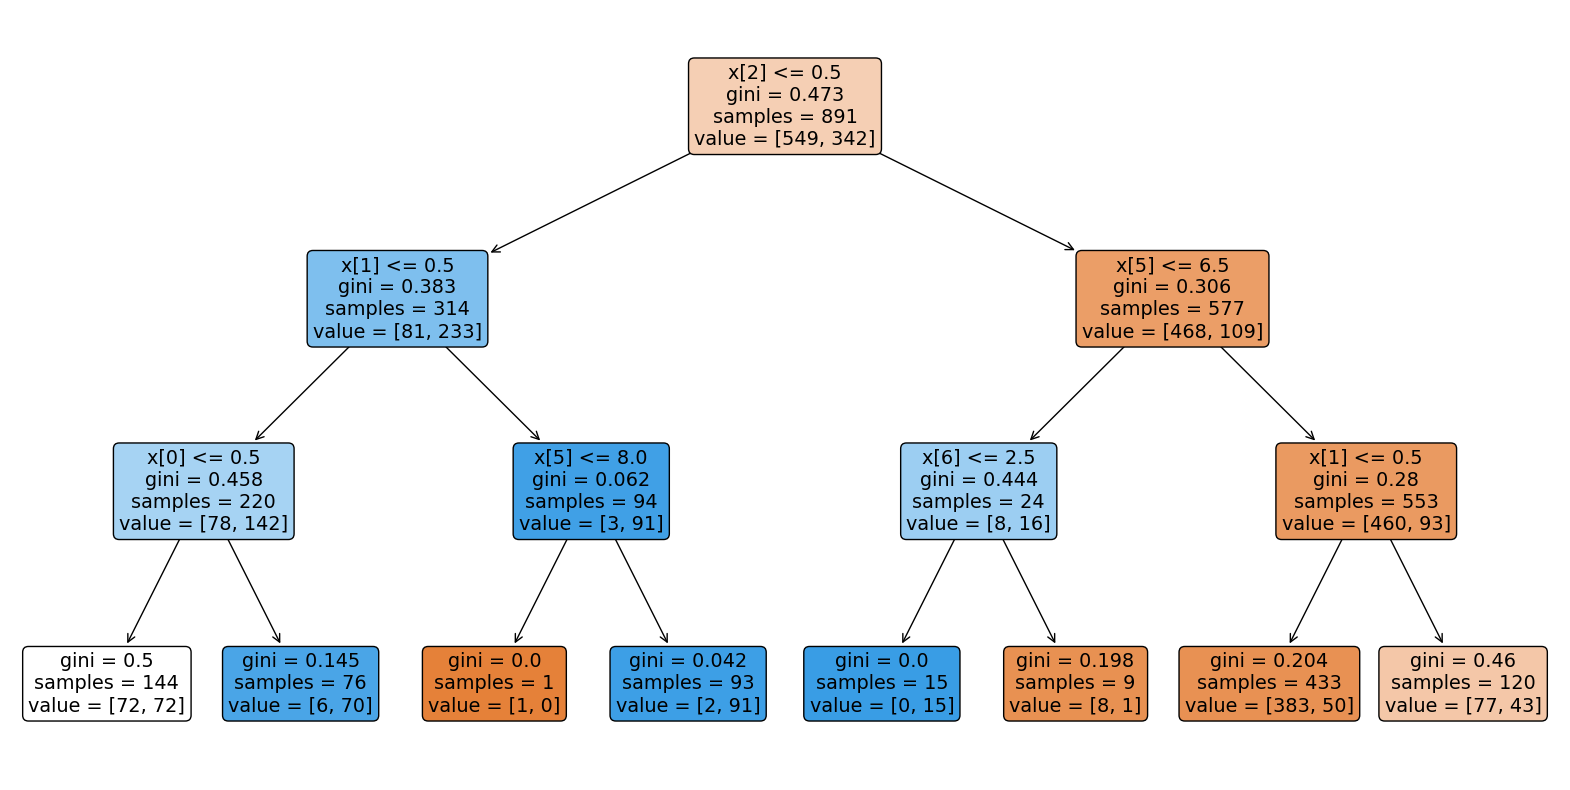

In [20]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Create Decision Tree classifer object with max_depth=3
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True)
plt.show()

In [21]:
X_train_final

,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
0,False,False,True,False,True,22.0,1,0,7.2500
1,False,True,False,False,False,38.0,1,0,71.2833
2,False,False,False,False,True,26.0,0,0,7.9250
3,False,True,False,False,True,35.0,1,0,53.1000
4,False,False,True,False,True,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...
886,True,False,True,False,True,27.0,0,0,13.0000
887,False,True,False,False,True,19.0,0,0,30.0000
888,False,False,False,False,True,28.0,1,2,23.4500
889,False,True,True,False,False,26.0,0,0,30.0000


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores parámetros encontrados:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.81      0.94      0.87       549
    Survived       0.86      0.65      0.74       342

    accuracy                           0.83       891
   macro avg       0.84      0.79      0.81       891
weighted avg       0.83      0.83      0.82       891

Exactitud:
0.8260381593714927


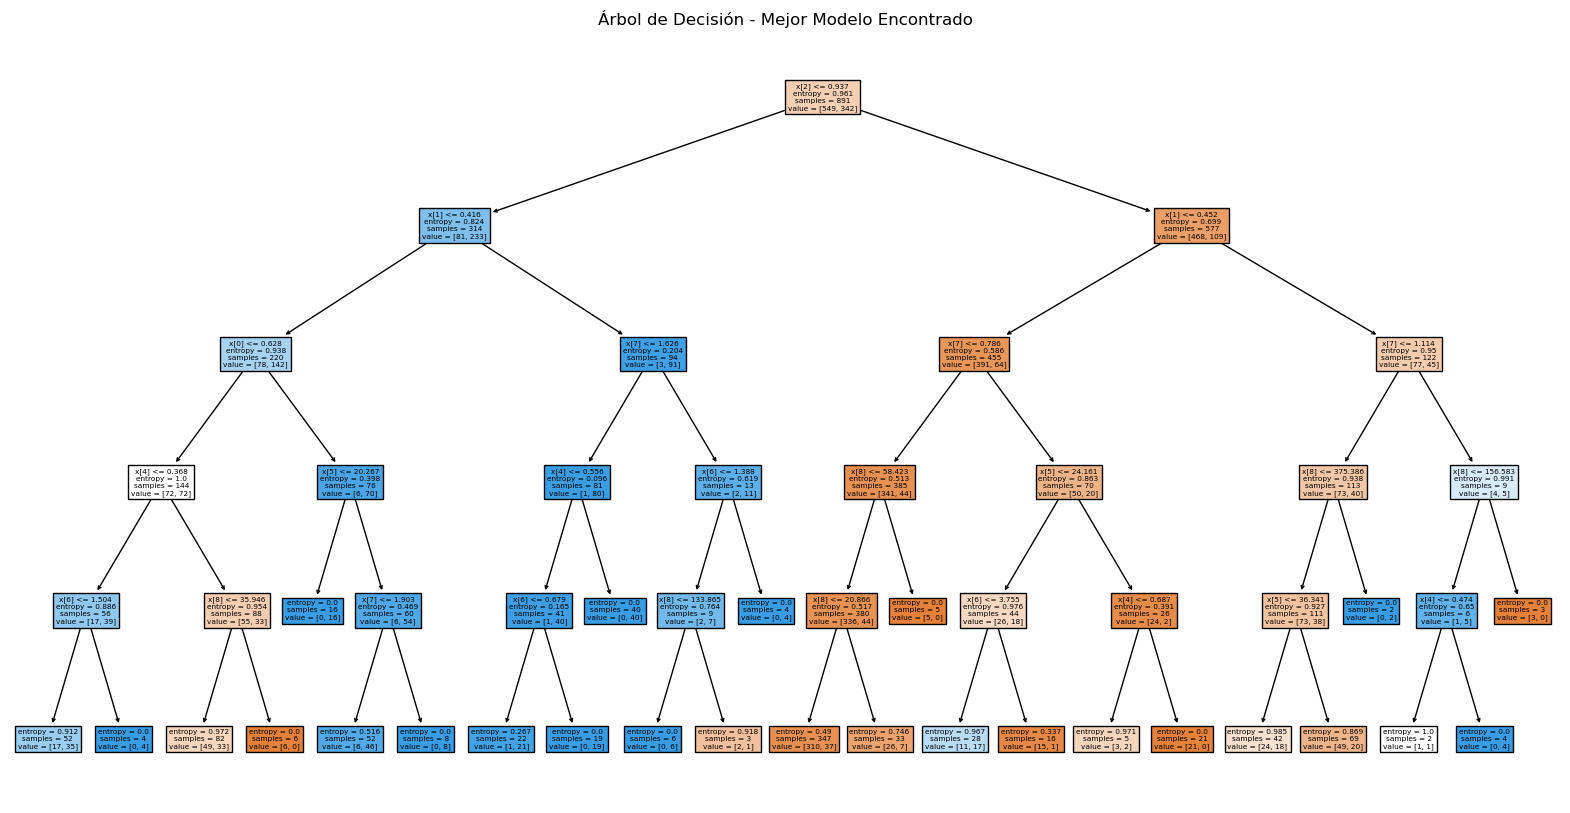

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
# Paso 3: Definir el modelo
dt = DecisionTreeClassifier()

# Paso 4: Definir los hiperparámetros a probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Paso 5: Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train)

# Paso 6: Obtener los mejores parámetros y evaluar el modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train_final)

print("Reporte de clasificación:")
print(classification_report(y_train, y_pred))

print("Exactitud:")
print(accuracy_score(y_train, y_pred))
# Paso 7: Graficar el mejor árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model,filled=True)
plt.title("Árbol de Decisión - Mejor Modelo Encontrado")
plt.show()